In [3]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from xgboost import XGBClassifier

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt 

In [4]:
data_filepath = '/kaggle/input/gestational-diabetes/Gestational Diabetes.csv'
data = pd.read_csv(data_filepath)

RANDOM_STATE = 1

In [5]:
duplicate_rows = data[data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

data = data.drop_duplicates()
print(f"Number of rows after removing duplicates: {data.shape[0]}")

Number of duplicate rows: 94
Number of rows after removing duplicates: 918


In [6]:
# Define a function to remove outliers based on the IQR method
def remove_outliers(df, feature):

    # Calculate the first quartile (Q1) and third quartile (Q3) of the feature
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define the outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame to exclude outliers
    df_cleaned = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    
    return df_cleaned

# List of features to check for outliers
features = ['Age', 'Weight', 'Height', 'BMI']

# Apply the outlier removal function to each feature
for feature in features:
    data = remove_outliers(data, feature)

# Display the cleaned DataFrame shape
print("Shape of DataFrame after outlier removal:", data.shape)

Shape of DataFrame after outlier removal: (892, 7)


In [7]:
features = ["Age", "Pregnancy No", "Height", "Weight", "BMI", "Heredity"]
X = data[features]
y = data["Prediction"]

# Split for Test set
X, X_test, y, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2)

# Split for crossvalidation set
X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

# # Feature Scaling 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

In [8]:
# Train the decision tree model (XGBOOST)
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train, y_train, eval_set = [(X_dev, y_dev)], early_stopping_rounds = 10)
xgb_model.best_iteration

y_train_pred_xgb = xgb_model.predict(X_train)
y_dev_pred_xgb = xgb_model.predict(X_dev)

training_accuracy = accuracy_score(y_train, y_train_pred_xgb)
cv_accuracy = accuracy_score(y_dev, y_dev_pred_xgb)

print(f"Training Accuracy: {training_accuracy:.2f}, Validation Accuracy {cv_accuracy:.2f}")

[0]	validation_0-logloss:0.51524
[1]	validation_0-logloss:0.48775
[2]	validation_0-logloss:0.46512
[3]	validation_0-logloss:0.44898
[4]	validation_0-logloss:0.43681
[5]	validation_0-logloss:0.42550
[6]	validation_0-logloss:0.41721
[7]	validation_0-logloss:0.40980
[8]	validation_0-logloss:0.40207
[9]	validation_0-logloss:0.39536
[10]	validation_0-logloss:0.39044
[11]	validation_0-logloss:0.38592
[12]	validation_0-logloss:0.38195
[13]	validation_0-logloss:0.37781
[14]	validation_0-logloss:0.37521
[15]	validation_0-logloss:0.37192
[16]	validation_0-logloss:0.37010
[17]	validation_0-logloss:0.36812
[18]	validation_0-logloss:0.36838
[19]	validation_0-logloss:0.36787
[20]	validation_0-logloss:0.36707
[21]	validation_0-logloss:0.36705
[22]	validation_0-logloss:0.36817
[23]	validation_0-logloss:0.36822
[24]	validation_0-logloss:0.36775
[25]	validation_0-logloss:0.36446
[26]	validation_0-logloss:0.36427
[27]	validation_0-logloss:0.36481
[28]	validation_0-logloss:0.36385
[29]	validation_0-loglos

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy: 0.84
Precision: 0.63
Recall: 0.53
F1-Score: 0.58


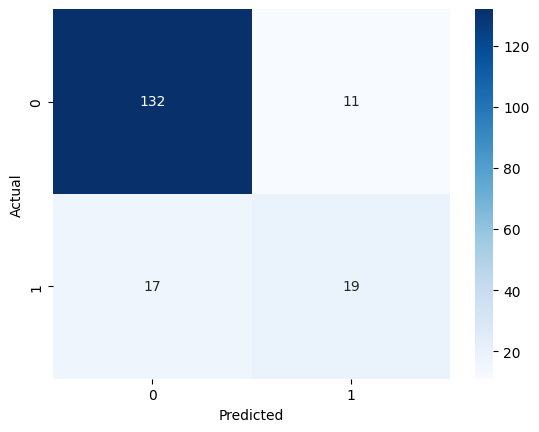

In [9]:
# Report 
y_test_pred_xgb = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred_xgb)
precision = precision_score(y_test, y_test_pred_xgb)
recall = recall_score(y_test, y_test_pred_xgb)
f1 = f1_score(y_test, y_test_pred_xgb)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
xgb_model.save_model("gestational_diabetes_xgb_model.json")

In [12]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.load_model("gestational_diabetes_xgb_model.json")

In [13]:
# Make predictions on test set
y_pred = xgb_model.predict(X_test)

# Print predictions (optional)
print("Predicted labels:", y_pred)

# Evaluate performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Predicted labels: [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0]
Accuracy: 0.8435754189944135

Confusion Matrix:
 [[132  11]
 [ 17  19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       143
           1       0.63      0.53      0.58        36

    accuracy                           0.84       179
   macro avg       0.76      0.73      0.74       179
weighted avg       0.84      0.84      0.84       179



In [18]:
# Collect input from user
age = float(input("Enter Age: "))
pregnancies = float(input("Enter Pregnancy No: "))
weight = float(input("Enter Weight (kg): "))
height = float(input("Enter Height (cm): "))
bmi = float(input("Enter BMI: "))
heredity = int(input("Enter Heredity (1=Yes, 0=No): "))

user_input = np.array([[age, pregnancies, weight, height, bmi, heredity]])

# Scale and predict
scaled_input = scaler.transform(user_input)
prediction = xgb_model.predict(scaled_input)

result = "Diabetic" if prediction[0] == 1 else "Not Diabetic"
print("Prediction Result:", result)


Enter Age:  18
Enter Pregnancy No:  1
Enter Weight (kg):  55
Enter Height (cm):  156
Enter BMI:  22.6
Enter Heredity (1=Yes, 0=No):  1


Prediction Result: Not Diabetic


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
